In [1]:
import sys
sys.path.append("..")

import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from dataset import TextureDataset
from configs.templates import pancancer_autoenc
from configs.templates_cls import liver_cancer_types_cls
from linear_clf.manipulate.manipulate_linear_cls import ImageManipulator, compute_structural_similarity
from cmcrameri import cm
from PIL import Image
from huggingface_hub import hf_hub_download, login
from torchvision import transforms
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

os.chdir("..")

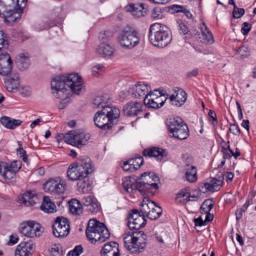

In [2]:
filename = "TCGA-3X-AAVA-01Z-00-DX1_0_0_5_506.png"
img = Image.open(f"images/example_data/{filename}").convert('RGB')
img

In [ ]:
# for downloading pretrained MoPadi models authenticate with a Hugging Face API token
token = input("Enter your Hugging Face API token: ")
login(token=token)

# or set your Hugging Face token as an environment variable by running `export HF_TOKEN="your_token_here`
#token = os.getenv("HF_TOKEN")
#login(token=token)

In [3]:
# download model files
autoenc_model_path = hf_hub_download(
    repo_id="KatherLabEKFZ/MoPaDi",
    filename="pancancer_model/autoenc.ckpt",
)
print(f"Autoencoder's checkpoint downloaded to: {autoenc_model_path}")

clf_model_path = hf_hub_download(
    repo_id="KatherLabEKFZ/MoPaDi",
    filename="pancancer_model/linear_liver_classifier.ckpt",
)
print(f"Classifier's checkpoint downloaded to: {clf_model_path}")

Autoencoder's checkpoint downloaded to: /home/laura/.cache/huggingface/hub/models--KatherLabEKFZ--MoPaDi/snapshots/aa49eb5fd594ec1d1c65ec418f65e2003d503693/pancancer_model/autoenc.ckpt
Classifier's checkpoint downloaded to: /home/laura/.cache/huggingface/hub/models--KatherLabEKFZ--MoPaDi/snapshots/aa49eb5fd594ec1d1c65ec418f65e2003d503693/pancancer_model/linear_liver_classifier.ckpt


In [4]:
# initialize the image manipulator
manipulator = ImageManipulator(
    autoenc_config = pancancer_autoenc(),
    autoenc_path = autoenc_model_path, 
    cls_config = liver_cancer_types_cls(), 
    cls_path = clf_model_path
)

Seed set to 0


Model params: 160.69 M


Seed set to 0


loading pretrain ... Pancancer
step: 568659
loading latent stats ...
latent step: 4687
Both models loaded successfully.
Valid target classes: ['Cholangiocarcinoma', 'Liver_hepatocellular_carcinoma']


In [5]:
res = []
lvls = [0.2, 0.4, 0.6, 0.8, 1.0]
    
for i in tqdm(lvls, desc="Manipulating images..."):
    res.append(manipulator.manipulate_image(
                        img=img, 
                        target_class="Liver_hepatocellular_carcinoma",
                        manipulation_amplitude=i,
                        save_path="images/example_liver_cancer_types_linear",
                        save_fname_ori=filename.split(".")[0] + "_original.png",
    ))

Manipulating images...:   0%|          | 0/5 [00:00<?, ?it/s]

Manipulating images...: 100%|██████████| 5/5 [01:20<00:00, 16.18s/it]


### Metrics

In [6]:
sim = []
sim.append(compute_structural_similarity(res[0]["ori_img"].squeeze(), res[0]["ori_img"].squeeze()))

for i in range(len(res)):
   sim.append(compute_structural_similarity(res[i]["manip_img_rgb"], res[0]["ori_img"].squeeze()))

### Results

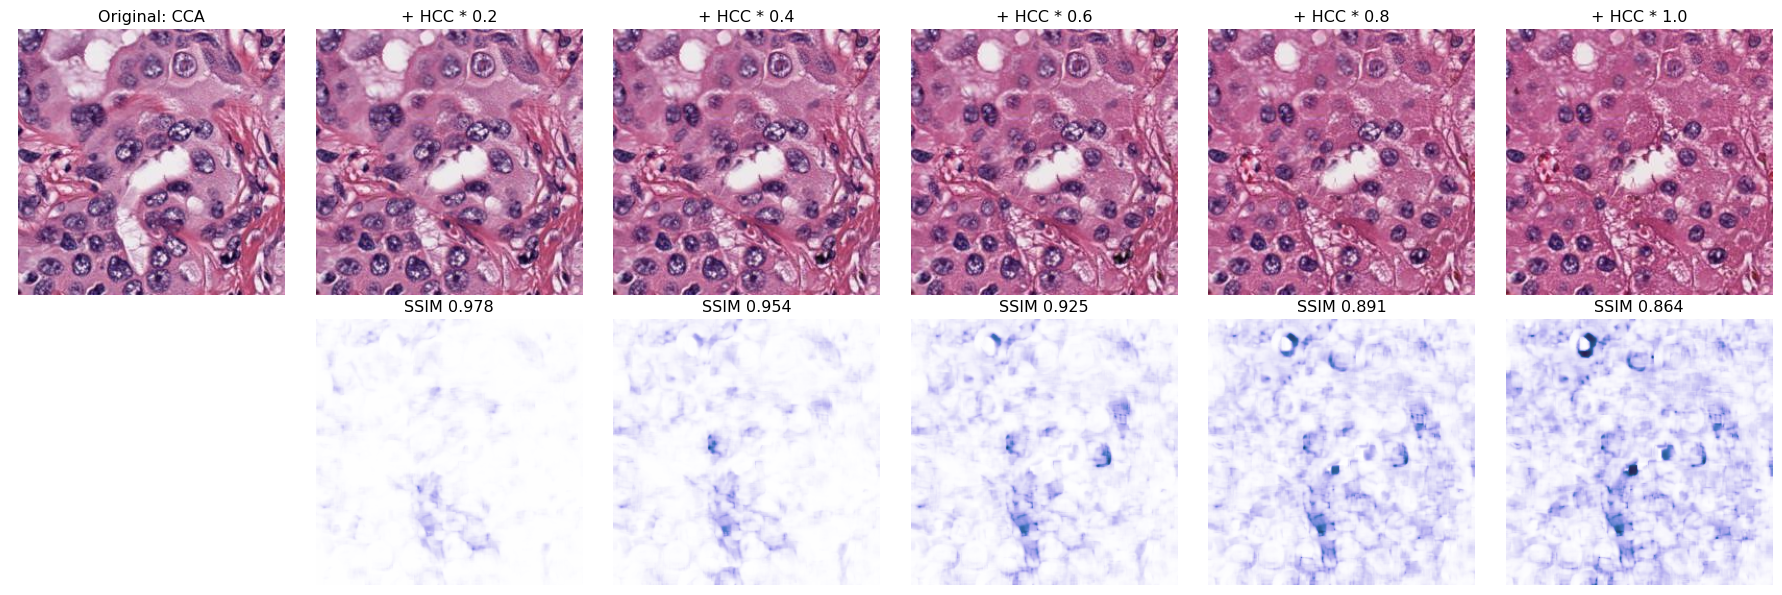

In [8]:
num_rows=2
num_cols=6

# scale all difference images for direct comparison
global_min = min([diff.min() for diff, _,_,_ in sim])
global_max = max([diff.max() for diff,_,_,_ in sim])

img_height, img_width = (300, 300)
dpi = 96 # Display resolution (dots per inch)
fig_width = (img_width * num_cols) / dpi
fig_height = (img_height * num_rows) / dpi

gt_class = 'CCA'
target_class = 'HCC'

fig, ax = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), dpi=dpi)

ori = res[0]["ori_img"]
ax[0,0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[0,0].axis('off')
ax[0,0].set_title(f'Original: {gt_class}')
ax[1,0].axis('off')

for i in range(len(res)):
    manip_img = res[i]["manip_img"].permute(1, 2, 0).cpu()
    ax[0,i+1].imshow(manip_img)
    ax[0,i+1].set_title(f"+ {target_class} * {str(lvls[i])}")
    ax[0,i+1].axis('off')

    ssim_image_rotated = np.rot90(sim[i+1][0], k=-1)
    flipped_ssim = np.fliplr(ssim_image_rotated)
    img = ax[1,i+1].imshow(flipped_ssim, cmap=cm.devon, vmin=global_min, vmax=global_max)
    ax[1,i+1].set_title("SSIM {sim:.3f}".format(sim = sim[i+1][1]))
    ax[1,i+1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join("images/example_liver_cancer_types_linear", "all_ssim.png"), bbox_inches='tight')

In [9]:
print(f"Targets: {res[0]['target_list']}")

with torch.no_grad():
    manipulator.classifier.ema_classifier.eval()

    latent_norm = manipulator.classifier.normalize(res[0]['ori_feats'])
    output = manipulator.classifier.ema_classifier.forward(latent_norm)                
    pred = torch.sigmoid(output)#, dim=1)
    _, max_index = torch.max(pred, 1)
    predicted_class = res[0]['target_list'][max_index.item()]
    print("Predictions for the original image:")
    print(res[0]['target_list'])
    print(f"{[f'{p:.3f}' for p in pred.cpu().numpy().flatten()]}")
    print(f"Predicted class: {predicted_class}")
    print('________________')

for i in range(len(res[:6])):
    print(f"Image manipulated at {lvls[i]}")
    print(res[i]['preds'])
    print(f"Predicted class: {res[i]['pred_class']}")

Targets: ['Cholangiocarcinoma', 'Liver_hepatocellular_carcinoma']
Predictions for the original image:
['Cholangiocarcinoma', 'Liver_hepatocellular_carcinoma']
['0.583', '0.334']
Predicted class: Cholangiocarcinoma
________________
Image manipulated at 0.2
['0.342', '0.658']
Predicted class: Liver_hepatocellular_carcinoma
Image manipulated at 0.4
['0.063', '0.937']
Predicted class: Liver_hepatocellular_carcinoma
Image manipulated at 0.6
['0.007', '0.993']
Predicted class: Liver_hepatocellular_carcinoma
Image manipulated at 0.8
['0.001', '0.999']
Predicted class: Liver_hepatocellular_carcinoma
Image manipulated at 1.0
['0.000', '1.000']
Predicted class: Liver_hepatocellular_carcinoma
